In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [77]:
import yfinance as yf
import pandas as pd

# Step 1: Fetch Historical Stock Data
# Download historical data
adobe = yf.download("ADBE", start="2010-01-01", end="2018-01-01")
microsoft = yf.download("MSFT", start="2010-01-01", end="2018-01-01")

# Combine data using merge
data = pd.merge(adobe['Close'], microsoft['Close'], left_index=True, right_index=True, suffixes=('_adobe', '_microsoft'))

# Rename columns for clarity
data.columns = ['adobe_close', 'microsoft_close']

# Check the combined data
print(data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

            adobe_close  microsoft_close
Date                                    
2010-01-04    37.090000        23.300678
2010-01-05    37.700001        23.308201
2010-01-06    37.619999        23.165167
2010-01-07    36.889999        22.924253
2010-01-08    36.689999        23.082354


In [78]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

def compute_hedge_ratio(x, y):
    """Computes hedge ratio using Kalman Filter Regression."""
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    return -state_means[:, 0]

def compute_spread(df):
    """Computes the spread series."""
    df['spread'] = df['y'] + (df['x'] * df['hr'])

def compute_residuals(df):
    """Computes residuals from the Kalman Filter."""
    df['residuals'] = df['spread'] - df['spread'].ewm(span=30).mean()

def compute_volatility(df, window=30):
    """Calculates rolling volatility of residuals."""
    df['volatility'] = df['residuals'].rolling(window=window).std()

def compute_z_score(df, halflife):
    """Computes the rolling Z-score of the spread."""
    mean_spread = df.spread.rolling(window=halflife).mean()
    std_spread = df.spread.rolling(window=halflife).std()
    df['zScore'] = (df.spread - mean_spread) / std_spread

def generate_volatility_based_signals(df, entry_mult=1.5, exit_mult=0.5):
    """Generates trading signals based on volatility-adjusted thresholds."""
    df['vol_entry'] = entry_mult * df['volatility']
    df['vol_exit'] = exit_mult * df['volatility']
    df['long entry'] = (df['zScore'] < -df['vol_entry']) & (df['zScore'].shift(1) > -df['vol_entry'])
    df['long exit'] = (df['zScore'] > -df['vol_exit']) & (df['zScore'].shift(1) < -df['vol_exit'])
    df['short entry'] = (df['zScore'] > df['vol_entry']) & (df['zScore'].shift(1) < df['vol_entry'])
    df['short exit'] = (df['zScore'] < df['vol_exit']) & (df['zScore'].shift(1) > df['vol_exit'])

def generate_z_score_signals(df, entry_z=1.7, exit_z=0):
    """Generates trading signals based on fixed Z-score thresholds."""
    df['long entry'] = (df.zScore < -entry_z) & (df.zScore.shift(1) > -entry_z)
    df['long exit'] = (df.zScore > -exit_z) & (df.zScore.shift(1) < -exit_z)
    df['short entry'] = (df.zScore > entry_z) & (df.zScore.shift(1) < entry_z)
    df['short exit'] = (df.zScore < exit_z) & (df.zScore.shift(1) > exit_z)

def calculate_positions(df):
    """Determines position sizes based on entry and exit signals."""
    df['num units long'] = np.nan
    df.loc[df['long entry'], 'num units long'] = 1
    df.loc[df['long exit'], 'num units long'] = 0
    df['num units long'].fillna(method='pad', inplace=True)
    df['num units long'].iloc[0] = 0

    df['num units short'] = np.nan
    df.loc[df['short entry'], 'num units short'] = -1
    df.loc[df['short exit'], 'num units short'] = 0
    df['num units short'].fillna(method='pad', inplace=True)
    df['num units short'].iloc[0] = 0
    
    df['numUnits'] = df['num units long'] + df['num units short']

def compute_portfolio_returns(df):
    """Computes portfolio returns and cumulative returns."""
    df['spread pct ch'] = (df['spread'] - df['spread'].shift(1)) / ((df['x'] * abs(df['hr'])) + df['y'])
    df['port rets'] = df['spread pct ch'] * df['numUnits'].shift(1)
    df['cum rets'] = df['port rets'].cumsum() + 1

def compute_sharpe_ratio(df):
    """Computes the Sharpe ratio of the strategy."""
    try:
        return (df['port rets'].mean() / df['port rets'].std()) * sqrt(252)
    except ZeroDivisionError:
        return 0.0

def backtest(s1, s2, x, y, entry_thresh, exit_thresh, strategy='volatility'):
    """Main backtesting function, supports volatility-based and Z-score strategies."""
    df = pd.DataFrame({'y': y, 'x': x})
    df['hr'] = compute_hedge_ratio(x, y)
    
    compute_spread(df)
    compute_residuals(df)
    compute_volatility(df)
    
    halflife = half_life(df['spread'])
    compute_z_score(df, halflife)
    
    if strategy == 'volatility':
        generate_volatility_based_signals(df, entry_mult=entry_thresh, exit_mult=exit_thresh)
    else:
        generate_z_score_signals(df)
    
    calculate_positions(df)
    compute_portfolio_returns(df)
    sharpe = compute_sharpe_ratio(df)
    
    return df['cum rets'], sharpe

def compare_strategies(s1, s2, x, y):
    """Compares volatility-based and Z-score-based trading strategies."""
    cum_rets_vol, sharpe_vol = backtest(s1, s2, x, y, strategy='volatility')
    cum_rets_z, sharpe_z = backtest(s1, s2, x, y, strategy='z-score')
    
    plt.figure(figsize=(10, 6))
    plt.plot(cum_rets_vol, label=f'Volatility-based Strategy (Sharpe={sharpe_vol:.2f})')
    plt.plot(cum_rets_z, label=f'Z-score-based Strategy (Sharpe={sharpe_z:.2f})')
    plt.legend()
    plt.title("Comparison of Trading Strategies")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.show()
    
    return {
        'volatility': {'cumulative_returns': cum_rets_vol, 'sharpe_ratio': sharpe_vol},
        'z-score': {'cumulative_returns': cum_rets_z, 'sharpe_ratio': sharpe_z}
    }


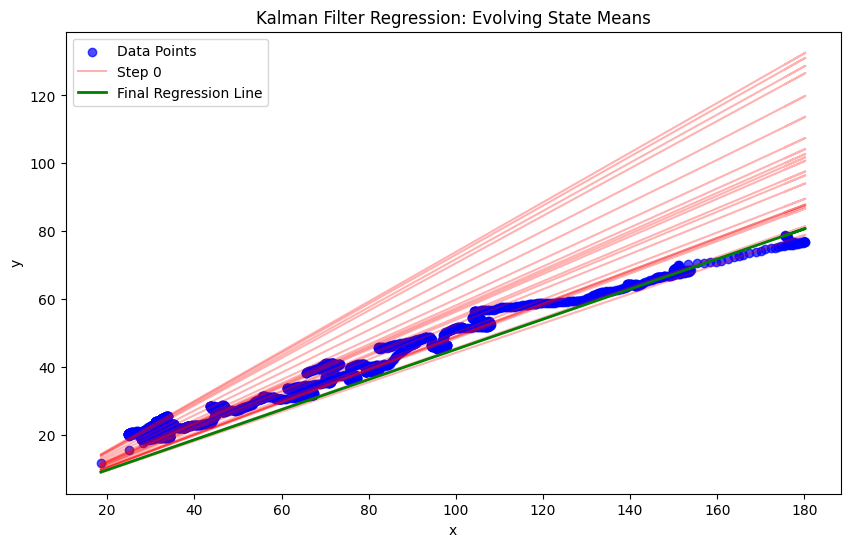

In [82]:
df_cum_rets, sharpe = backtest(    s1="ADBE",
    s2="MSFT",
    x=data['adobe_close'],
    y=data['microsoft_close'],
    entry_thresh = 2,
    exit_thresh = 2
)

In [83]:
sharpe

0.8407434551897268

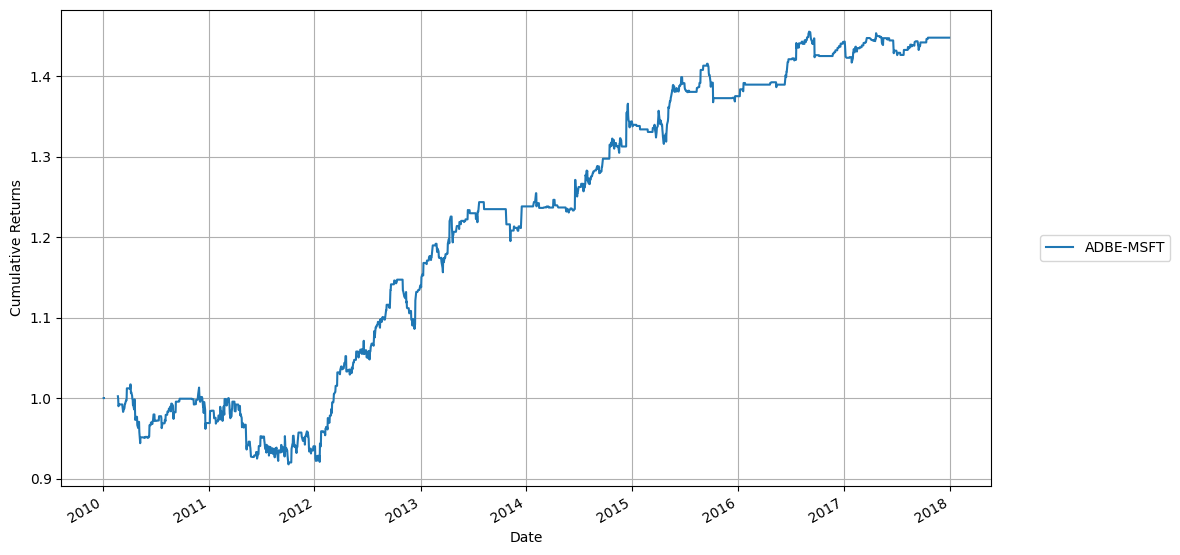

Stat                 ADBE-MSFT
-------------------  -----------
Start                2010-01-04
End                  2017-12-29
Risk-free rate       0.00%

Total Return         44.79%
Daily Sharpe         0.80
Daily Sortino        1.34
CAGR                 4.75%
Max Drawdown         -9.77%
Calmar Ratio         0.49

MTD                  0.00%
3m                   0.41%
6m                   1.13%
YTD                  0.36%
1Y                   0.36%
3Y (ann.)            2.52%
5Y (ann.)            4.90%
10Y (ann.)           -
Since Incep. (ann.)  4.75%

Daily Sharpe         0.80
Daily Sortino        1.34
Daily Mean (ann.)    4.90%
Daily Vol (ann.)     6.15%
Daily Skew           1.17
Daily Kurt           13.16
Best Day             3.20%
Worst Day            -2.40%

Monthly Sharpe       0.82
Monthly Sortino      1.48
Monthly Mean (ann.)  4.86%
Monthly Vol (ann.)   5.93%
Monthly Skew         -0.27
Monthly Kurt         1.21
Best Month           4.93%
Worst Month          -4.52%

Yearly Sharp

In [84]:
ret = pd.DataFrame()
ret['ADBE-MSFT'] = df_cum_rets.values
# Show the results of in-sample testing
ret.iloc[0] = 1
ret.index = data.index
ret.plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns')
plt.show()
# Calculate the performance
perf = ret.calc_stats()
perf.display()

In [86]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

def compute_hedge_ratio(x, y):
    """Computes hedge ratio using Kalman Filter Regression."""
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    return -state_means[:, 0]

def compute_spread(df):
    """Computes the spread series."""
    df['spread'] = df['y'] + (df['x'] * df['hr'])

def compute_residuals(df):
    """Computes residuals from the Kalman Filter."""
    df['residuals'] = df['spread'] - df['spread'].ewm(span=30).mean()

def compute_volatility(df, window=30):
    """Calculates rolling volatility of residuals."""
    df['volatility'] = df['residuals'].rolling(window=window).std()

def compute_z_score(df, halflife):
    """Computes the rolling Z-score of the spread."""
    mean_spread = df.spread.rolling(window=halflife).mean()
    std_spread = df.spread.rolling(window=halflife).std()
    df['zScore'] = (df.spread - mean_spread) / std_spread

def generate_volatility_based_signals(df, entry_mult=2, exit_mult=2):
    """Generates buy/sell signals based on volatility-adjusted thresholds."""
    df['vol_entry'] = entry_mult * df['volatility']
    df['vol_exit'] = exit_mult * df['volatility']
    
    df['long entry'] = (df['zScore'] < -df['vol_entry']) & (df['zScore'].shift(1) > -df['vol_entry'])
    df['long exit'] = (df['zScore'] > -df['vol_exit']) & (df['zScore'].shift(1) < -df['vol_exit'])
    df['short entry'] = (df['zScore'] > df['vol_entry']) & (df['zScore'].shift(1) < df['vol_entry'])
    df['short exit'] = (df['zScore'] < df['vol_exit']) & (df['zScore'].shift(1) > df['vol_exit'])

def generate_z_score_signals(df, entry_z=1.7, exit_z=0):
    """Generates buy/sell signals based on fixed Z-score thresholds."""
    df['long entry'] = (df.zScore < -entry_z) & (df.zScore.shift(1) > -entry_z)
    df['long exit'] = (df.zScore > -exit_z) & (df.zScore.shift(1) < -exit_z)
    df['short entry'] = (df.zScore > entry_z) & (df.zScore.shift(1) < entry_z)
    df['short exit'] = (df.zScore < exit_z) & (df.zScore.shift(1) > exit_z)

def calculate_positions(df):
    """Determines position sizes based on entry and exit signals."""
    df['num units long'] = np.nan
    df.loc[df['long entry'], 'num units long'] = 1
    df.loc[df['long exit'], 'num units long'] = 0
    df['num units long'].fillna(method='pad', inplace=True)
    df['num units long'].iloc[0] = 0

    df['num units short'] = np.nan
    df.loc[df['short entry'], 'num units short'] = -1
    df.loc[df['short exit'], 'num units short'] = 0
    df['num units short'].fillna(method='pad', inplace=True)
    df['num units short'].iloc[0] = 0
    
    df['numUnits'] = df['num units long'] + df['num units short']

def compute_portfolio_returns(df):
    """Computes portfolio returns and cumulative returns."""
    df['spread pct ch'] = (df['spread'] - df['spread'].shift(1)) / ((df['x'] * abs(df['hr'])) + df['y'])
    df['port rets'] = df['spread pct ch'] * df['numUnits'].shift(1)
    df['cum rets'] = df['port rets'].cumsum() + 1

def compute_sharpe_ratio(df):
    """Computes the Sharpe ratio of the strategy."""
    try:
        return (df['port rets'].mean() / df['port rets'].std()) * sqrt(252)
    except ZeroDivisionError:
        return 0.0

def backtest(s1, s2, x, y, entry_thresh=1.5, exit_thresh=0.5, strategy='volatility'):
    """Main backtesting function, supports volatility-based and Z-score strategies."""
    df = pd.DataFrame({'y': y, 'x': x})
    df['hr'] = compute_hedge_ratio(x, y)
    
    compute_spread(df)
    compute_residuals(df)
    compute_volatility(df)
    
    halflife = half_life(df['spread'])
    compute_z_score(df, halflife)
    
    if strategy == 'volatility':
        generate_volatility_based_signals(df, entry_mult=entry_thresh, exit_mult=exit_thresh)
    else:
        generate_z_score_signals(df)
    
    calculate_positions(df)
    compute_portfolio_returns(df)
    
    return df

def compare_strategies(s1, s2, x, y):
    """Compares volatility-based and Z-score-based trading strategies."""
    df_vol = backtest(s1, s2, x, y, strategy='volatility')
    df_z = backtest(s1, s2, x, y, strategy='z-score')

    # Plot cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(df_vol.index, df_vol['cum rets'], label='Volatility-based Strategy')
    plt.plot(df_z.index, df_z['cum rets'], label='Z-score-based Strategy')
    plt.legend()
    plt.title("Comparison of Trading Strategies")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.show()

    # Extract buy and sell signals for the volatility strategy
    buy_signals = df_vol[df_vol['long entry']]
    sell_signals = df_vol[df_vol['short entry']]
    
    # Plot buy/sell signals
    plt.figure(figsize=(10, 6))
    plt.plot(df_vol.index, df_vol['spread'], label="Spread", color='black')
    plt.scatter(buy_signals.index, buy_signals['spread'], marker='^', color='green', label="Buy Signal", alpha=1)
    plt.scatter(sell_signals.index, sell_signals['spread'], marker='v', color='red', label="Sell Signal", alpha=1)
    plt.xlabel("Time")
    plt.ylabel("Spread")
    plt.title("Volatility-Based Strategy: Buy & Sell Signals")
    plt.legend()
    plt.show()

    # Compute final P&L
    final_pnl_vol = df_vol['cum rets'].iloc[-1] - 1
    final_pnl_z = df_z['cum rets'].iloc[-1] - 1

    print(f"Final P&L (Volatility Strategy): {final_pnl_vol:.2f}")
    print(f"Final P&L (Z-score Strategy): {final_pnl_z:.2f}")

    return {
        'volatility': {'final_pnl': final_pnl_vol, 'sharpe_ratio': compute_sharpe_ratio(df_vol)},
        'z-score': {'final_pnl': final_pnl_z, 'sharpe_ratio': compute_sharpe_ratio(df_z)}
    }


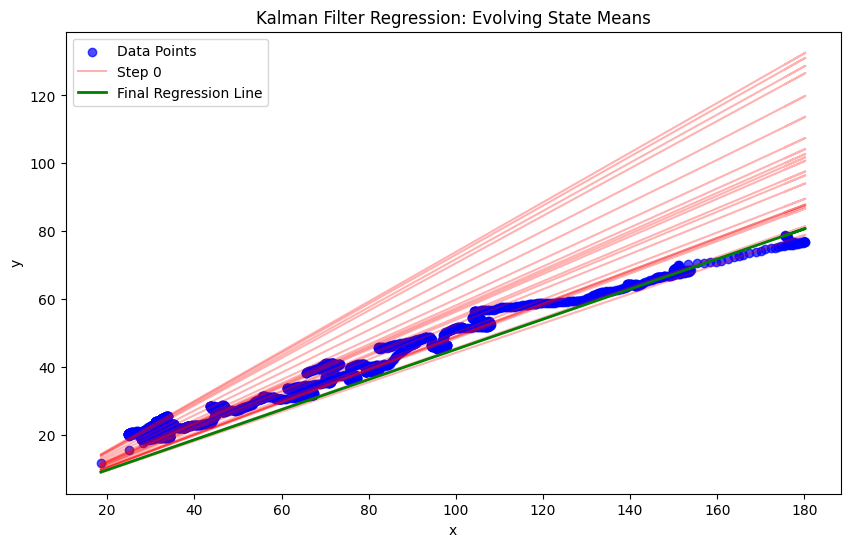

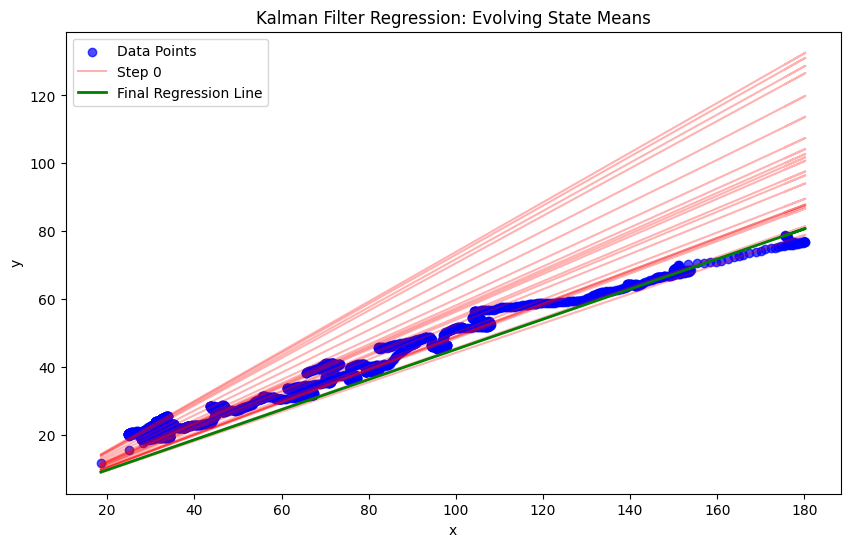

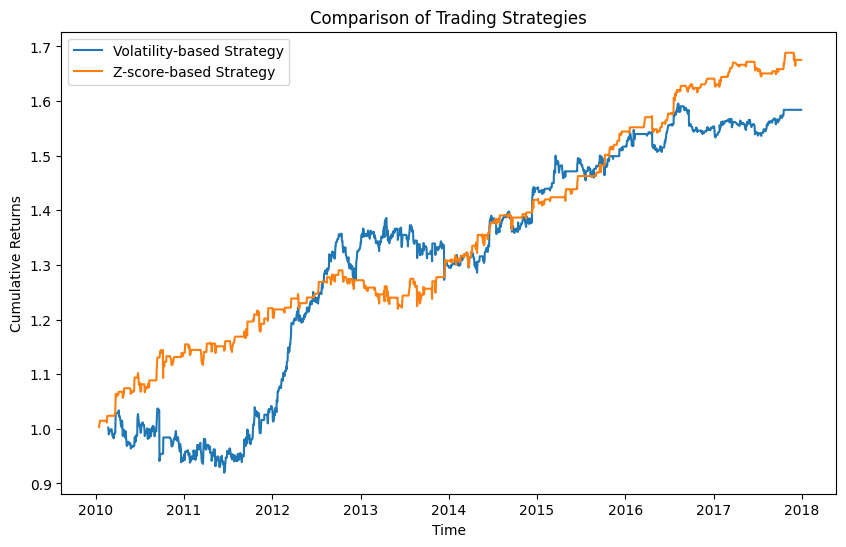

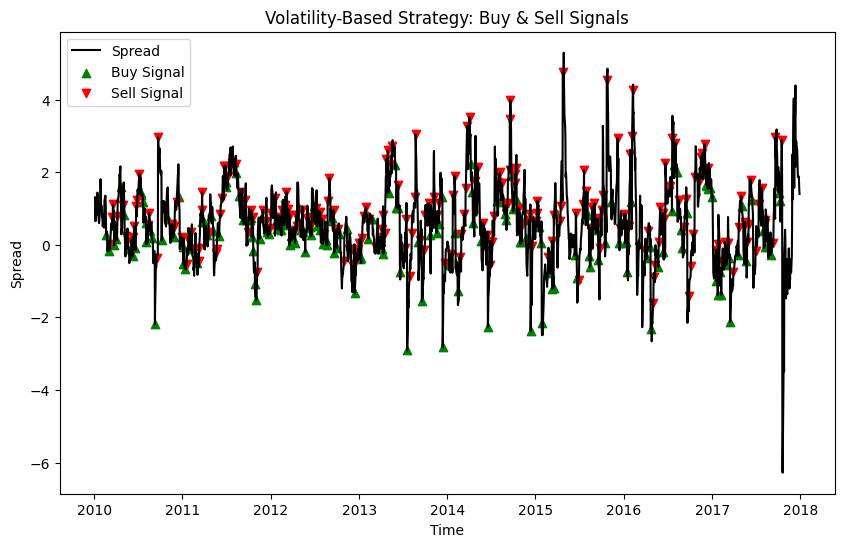

Final P&L (Volatility Strategy): 0.58
Final P&L (Z-score Strategy): 0.68


{'volatility': {'final_pnl': 0.5839909745309575,
  'sharpe_ratio': 0.7405582922990663},
 'z-score': {'final_pnl': 0.6754144262572186,
  'sharpe_ratio': 1.2612187491022258}}

In [87]:
compare_strategies(
        s1="ADBE",
    s2="MSFT",
    x=data['adobe_close'],
    y=data['microsoft_close']

)